In [2]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")

In [3]:
BASE_PATH = "/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/kaggle_3m/"



In [4]:
BASE_LEN = 132
END_LEN = 4
END_MASK_LEN = 9

IMG_SIZE = 512

# Get & Prepare Data

In [5]:
data = []

for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")
        
df = pd.DataFrame(data, columns=["dir_name", "image_path"])


[INFO] This is not a dir --> /home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/kaggle_3m/data.csv
[INFO] This is not a dir --> /home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/kaggle_3m/README.md
[INFO] This is not a dir --> /home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/kaggle_3m/README.pdf


In [6]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [7]:
df_imgs


,dir_name,image_path
0,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
1,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
5,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
7,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
...,...,...
7847,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
7849,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
7851,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
7853,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...


In [8]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

In [9]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5.tif*
 Belongs to the mask */home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5_mask.tif*


In [10]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
1,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
2,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
4,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...


In [11]:
dff


,patient,image_path,mask_path
0,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
1,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
2,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
4,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
...,...,...,...
3924,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3925,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3926,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3927,TCGA_HT_A61B_19991127,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...


In [12]:
def pos_neg_diagnosis(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0: return 1
    else: return 0

In [13]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
1,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
2,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
3,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
4,TCGA_CS_4941_19960909,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0


In [14]:
dff.shape

(3929, 4)

In [15]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [16]:
# !pip install albumentations==0.4.6

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [18]:

import albumentations as A


In [19]:
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
class BrainMRIDataset:
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transforms(image=image,
                                   mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"]
        
        return image, mask

In [22]:
PATCH_SIZE = 128

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensorV2(),
    
])

# Split Data and DataLoaders

In [23]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [24]:
stratify = dff.diagnosis
stratify

0       0
1       0
2       0
3       0
4       0
       ..
3924    0
3925    0
3926    0
3927    0
3928    0
Name: diagnosis, Length: 3929, dtype: int64

In [25]:
train_dataset = BrainMRIDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

val_dataset = BrainMRIDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

test_dataset = BrainMRIDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


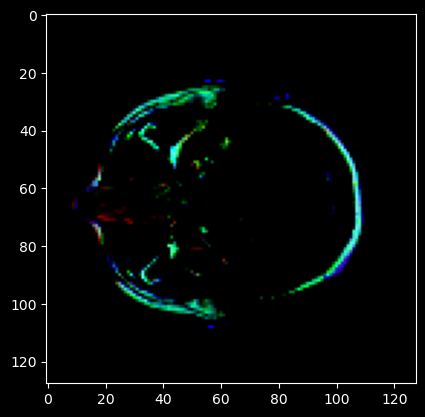

In [26]:
import matplotlib.pyplot as plt

# Access the dataset
dataset = train_dataloader.dataset

# Get the figure
figure = dataset[0]  # Assuming the figure is at index 0

# Visualize the figure
plt.imshow(np.array(figure[0].permute(1, 2, 0)))
plt.show()

In [27]:
def show_aug(inputs, nrows=5, ncols=5, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

In [ ]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


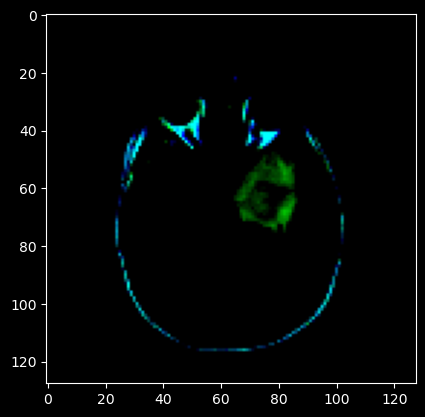

In [31]:
images.shape

plt.imshow(images[0].permute(1, 2, 0))

In [ ]:

show_aug(images)
show_aug(masks, norm=False)

# Attention U-Net

## Model Blocks

In [35]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [36]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [37]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

## Model

In [38]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=3, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

In [39]:
attention_unet = AttentionUNet(n_classes=1).to(device)

In [40]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

# Segmentation Metric

In [41]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

# Segmentation Loss

In [42]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [43]:
# sanity check
DiceLoss()(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1419)

# Training

In [44]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [45]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [46]:
opt = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

In [47]:
%%time
num_ep = 50
# after 30 does not improve much

aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)

[INFO] Model is initializing... Attention UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: -0.6875041728218396 
Mean DICE on train: 30.25053138987341 
Mean DICE on validation: 25.65458732412593


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: -0.7690996547540029 
Mean DICE on train: 27.485830602428063 
Mean DICE on validation: 27.318377881692072


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: -0.8149971961975098 
Mean DICE on train: 25.866531202414695 
Mean DICE on validation: 23.270715636938235


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: -0.8279580156008403 
Mean DICE on train: 25.208849763800732 
Mean DICE on validation: 24.602906863165106


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: -0.8475756138563156 
Mean DICE on train: 23.816809588544793 
Mean DICE on validation: 17.459893499922448


  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

In [49]:
plot_model_history("Attention U-Net", aun_th, aun_vh, num_ep)

NameError: name 'aun_th' is not defined

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(attention_unet, test_dataloader)
print(f"""Attention U-Net\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

# Different Loss Functions and Comparisons
## For 5 Epochs

In [ ]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [ ]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [ ]:
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#=====
#Multi-class Lovasz loss
#=====

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)

class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz

## Focal Loss

In [ ]:
%%time
num_ep = 5

aun_lh2, aun_th2, aun_vh2 = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, FocalLoss(), opt, False, num_ep)

In [ ]:
plot_model_history("Focal Loss Attention U-Net", aun_th2, aun_vh2, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh2)

## Focal Tversky Loss

In [ ]:
%%time
num_ep = 5

aun_lh3, aun_th3, aun_vh3 = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, FocalTverskyLoss(), opt, False, num_ep)

In [ ]:
plot_model_history("Focal Tversky Loss Attention U-Net", aun_th3, aun_vh3, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh3)